In [1]:
import cv2 as cv
import numpy as np
import glob
import pickle
import ml_metrics
import math
import os
import yaml
from evaluation_funcs import performance_accumulation_pixel 
from evaluation_funcs import performance_evaluation_pixel
from matplotlib import pyplot as plt

In [12]:
def compute_mask(img,name):
    
    # Computes channels in chosen color space
    c0 = img[:,:,0]
    c1 = img[:,:,1]
    c2 = img[:,:,2]
    
    # Height and width of channel (=image dims)
    height,width = c0.shape[:2]
        
    # Percentage defining number of pixels per every portion of the image
    percent_c0 = 0.02
    percent_c1 = 0.03
    percent_c2 = 0.02
    
    # Computes the amount of pixels per every channel
    aop_h_c0 = int(round(percent_c0 * height))
    aop_w_c0 = int(round(percent_c0 * width))
    
    aop_h_c1 = int(round(percent_c1 * height))
    aop_w_c1 = int(round(percent_c1 * width))
    
    aop_h_c2 = int(round(percent_c2 * height))
    aop_w_c2 = int(round(percent_c2 * width))
    
    # Defines image portions to get background pixels from
    portionc0_1 = c0[0:aop_h_c0, 0:width]
    portionc1_1 = c1[0:aop_h_c1, 0:width]
    portionc2_1 = c2[0:aop_h_c2, 0:width]
    
    if(BG_REMOVAL == 1) :
        # Method 1
        portionc0_2 = c0[height - aop_h_c0:height, 0:width]
        portionc1_2 = c1[height - aop_h_c1:height, 0:width]
        portionc2_2 = c2[height - aop_h_c2:height, 0:width]
    elif(BG_REMOVAL == 2):    
        # Method 2
        portionc0_2 = c0[0:height,0:aop_w_c0]
        portionc1_2 = c1[0:height,0:aop_w_c1]
        portionc2_2 = c2[0:height,0:aop_w_c2]
       
    # Computes minimum and max values per every portion and channel
    min_c0_1 = int(np.amin(portionc0_1))
    min_c1_1 = int(np.amin(portionc1_1))
    min_c2_1 = int(np.amin(portionc2_1))
    
    min_c0_2 = int(np.amin(portionc0_2))
    min_c1_2 = int(np.amin(portionc1_2))
    min_c2_2 = int(np.amin(portionc2_2))
    
    max_c0_1 = int(np.amax(portionc0_1))
    max_c1_1 = int(np.amax(portionc1_1))
    max_c2_1 = int(np.amax(portionc2_1))
    
    max_c0_2 = int(np.amax(portionc0_2))
    max_c1_2 = int(np.amax(portionc1_2))
    max_c2_2 = int(np.amax(portionc2_2))
    
    min_c0 = min(min_c0_1, min_c0_2)
    min_c1 = min(min_c1_1, min_c1_2)
    min_c2 = min(min_c2_1, min_c2_2)
    
    max_c0 = max(max_c0_1, max_c0_2)
    max_c1 = max(max_c1_1, max_c1_2)
    max_c2 = max(max_c2_1, max_c2_2)
    
    # Computes and saves the mask by thresholding every channel in the chosen color space
    mask = 255 - (cv.inRange(img,(min_c0, min_c1, min_c2),(max_c0, max_c1, max_c2)))

    # Save mask
    cv.imwrite('masks/' + name + '.png', mask)
    
    # Read ground truth
    g_t = cv.imread('../qs/' + QUERY_SET + '/' + name + '.png', cv.IMREAD_COLOR)
    g_t = cv.cvtColor(g_t, cv.COLOR_BGR2GRAY)
    
    # Compute evaluation metrics
    pixelTP, pixelFP, pixelFN, pixelTN = performance_accumulation_pixel(mask,g_t)
    pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity = performance_evaluation_pixel(pixelTP, pixelFP, pixelFN, pixelTN)
    F1 = 2*pixel_precision*pixel_sensitivity/(pixel_precision+pixel_sensitivity)
    
    eval_metrics = [pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity, F1]
    '''
    print("Precision: "+str(pixel_precision))
    print("Accuracy: "+str(pixel_accuracy))
    print("Specificity: "+str(pixel_specificity))
    print("Recall (sensitivity): "+str(pixel_sensitivity))
    print("F1: "+str(F1))
    '''
    return mask, eval_metrics


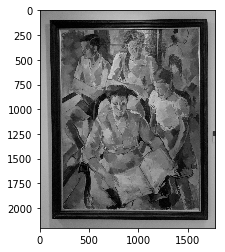

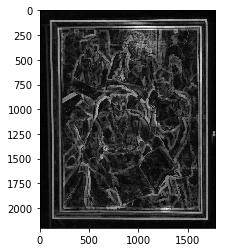

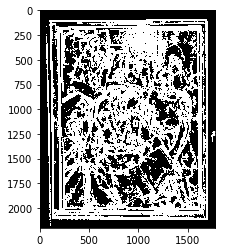

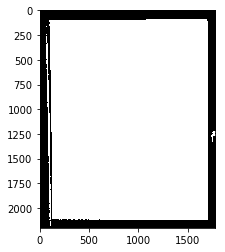

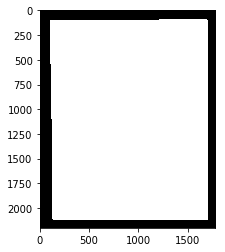

---------------------


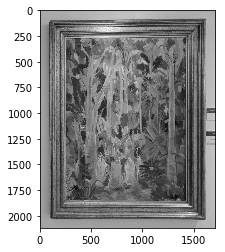

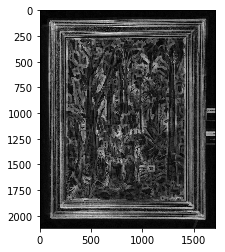

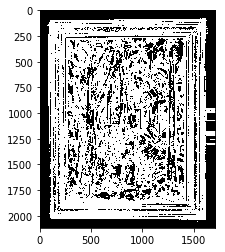

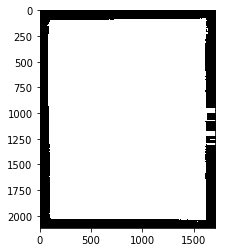

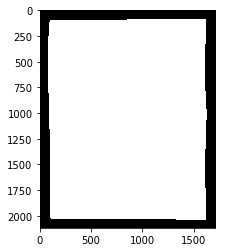

---------------------


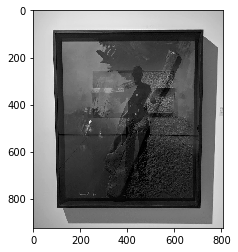

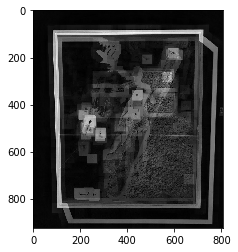

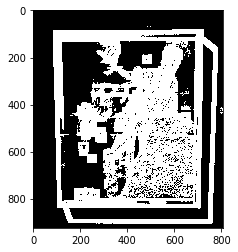

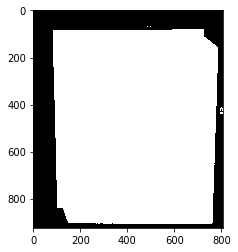

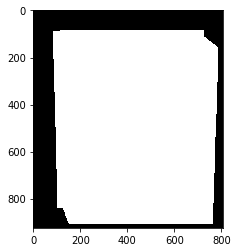

---------------------


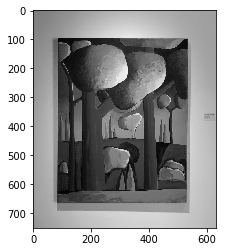

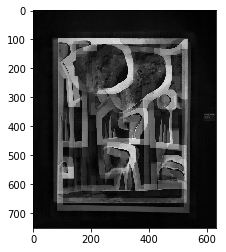

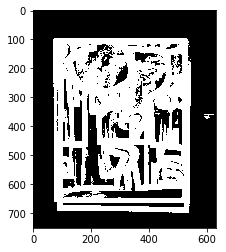

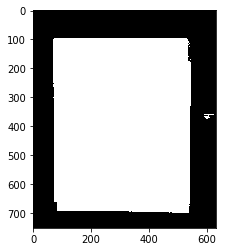

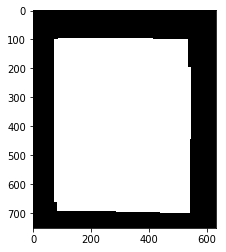

---------------------


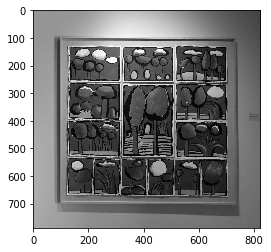

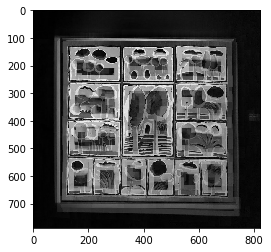

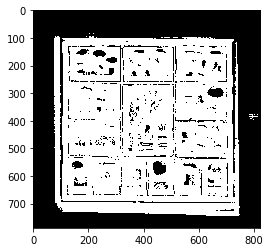

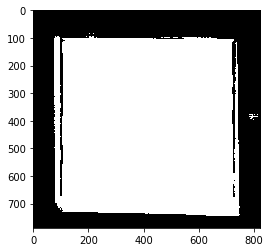

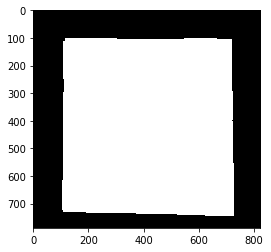

---------------------


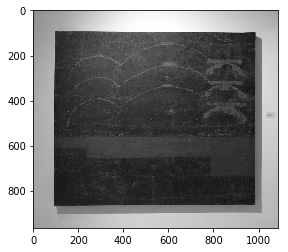

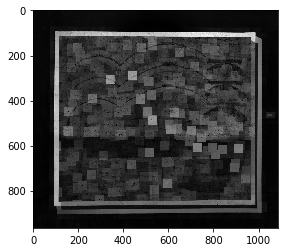

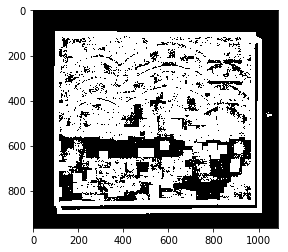

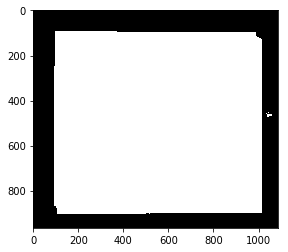

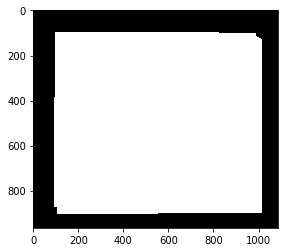

---------------------


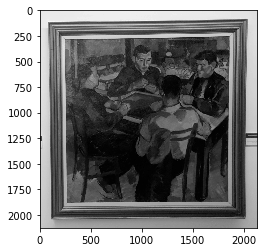

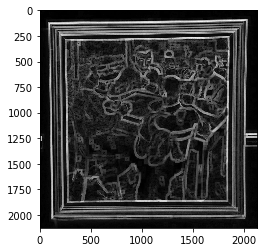

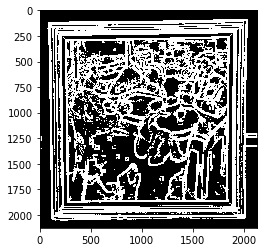

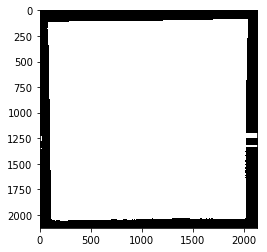

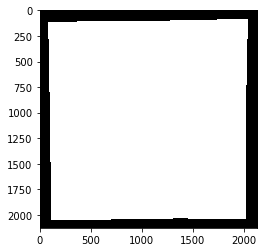

---------------------


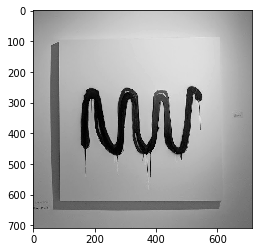

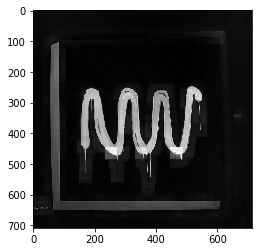

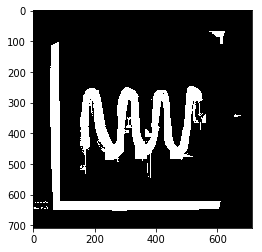

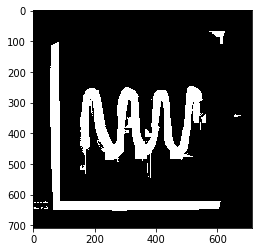

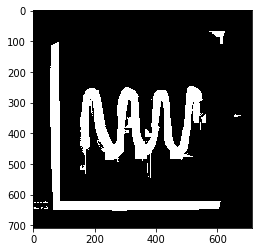

---------------------


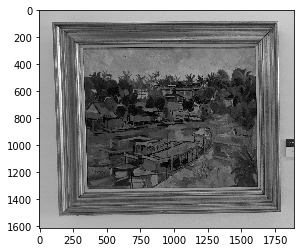

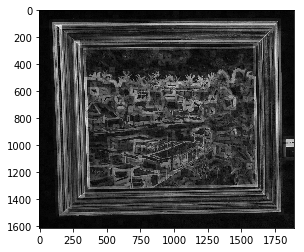

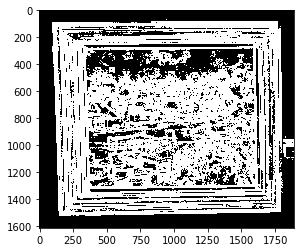

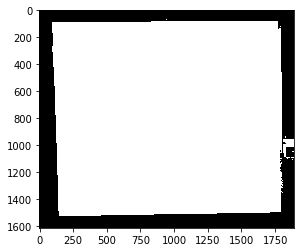

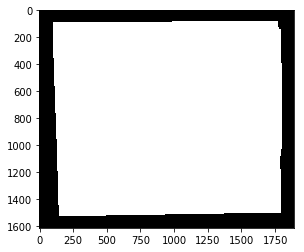

---------------------


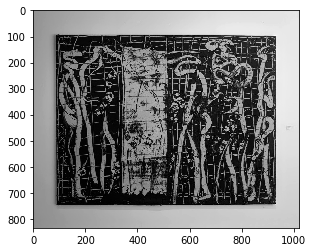

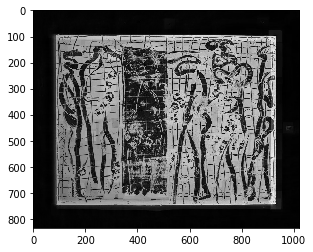

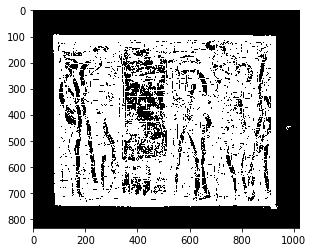

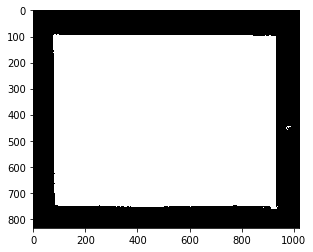

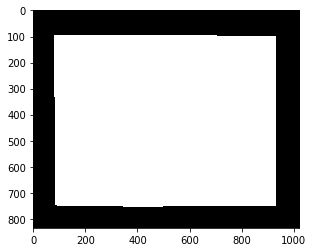

---------------------


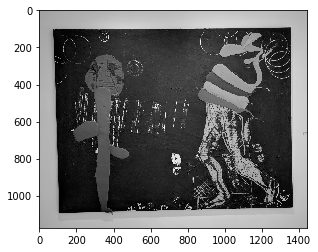

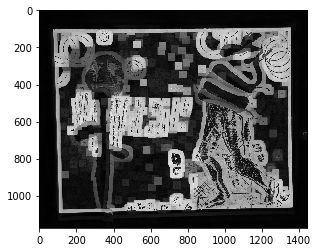

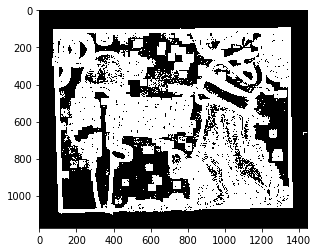

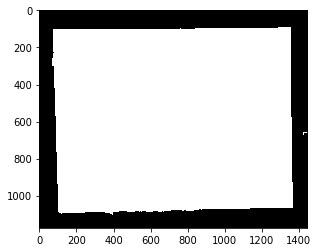

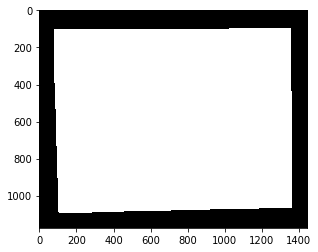

---------------------


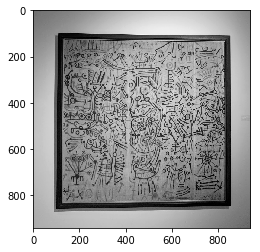

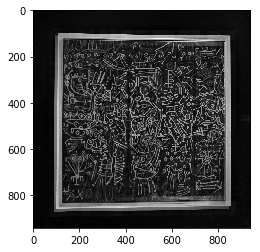

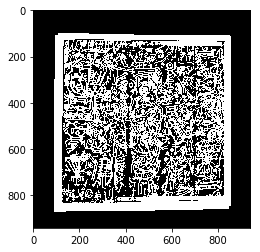

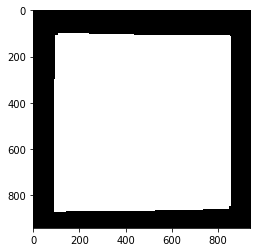

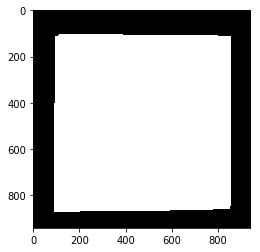

---------------------


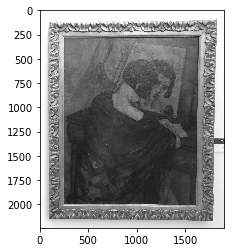

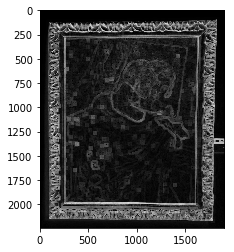

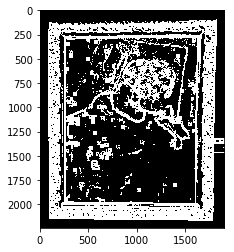

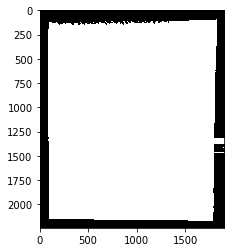

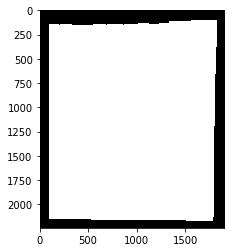

---------------------


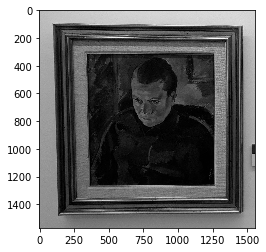

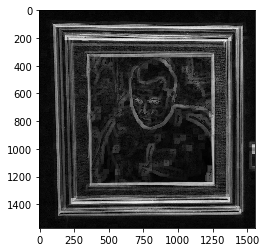

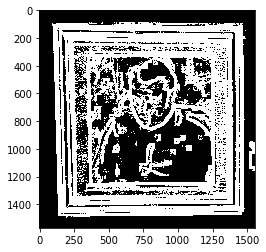

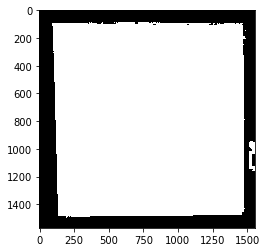

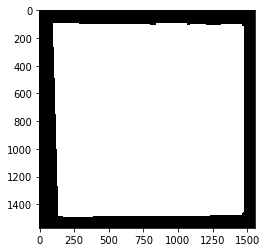

---------------------


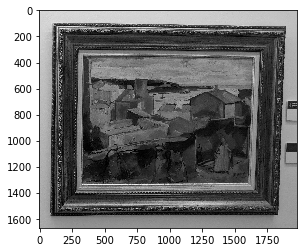

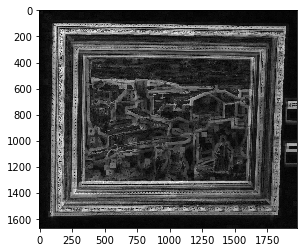

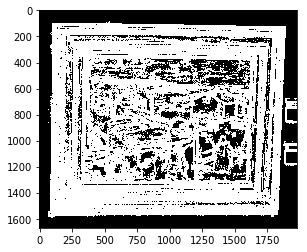

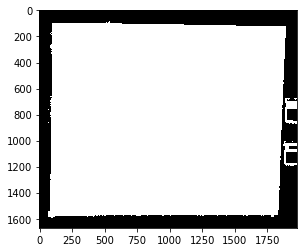

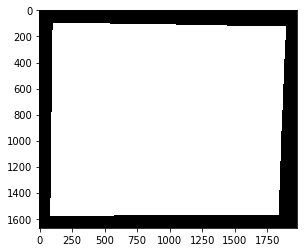

---------------------


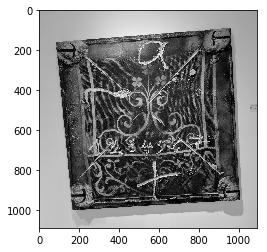

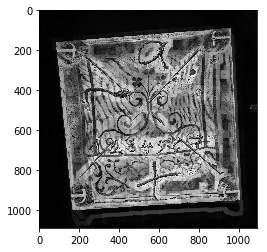

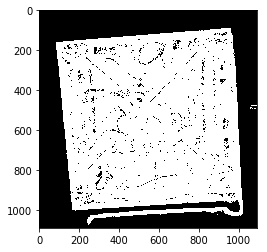

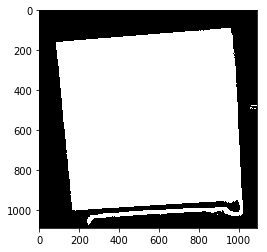

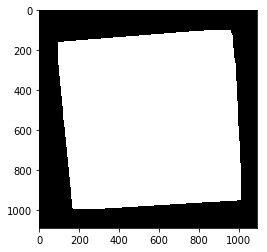

---------------------


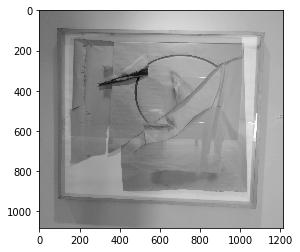

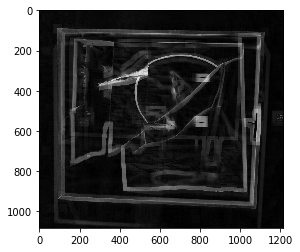

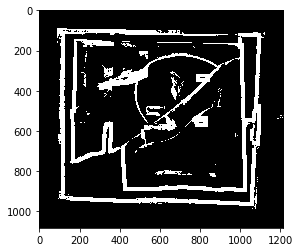

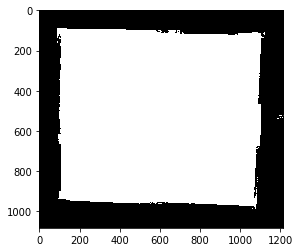

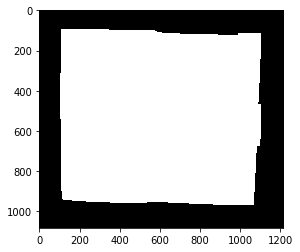

---------------------


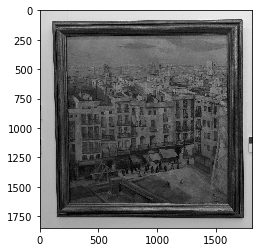

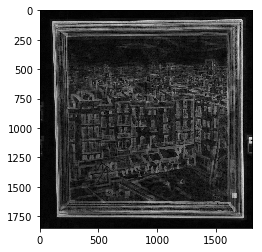

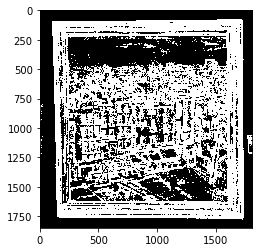

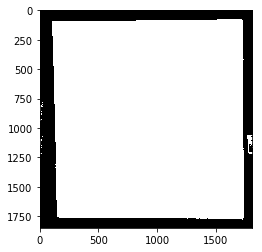

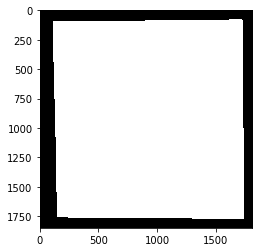

---------------------


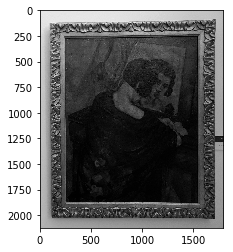

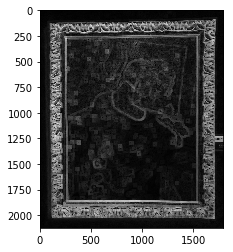

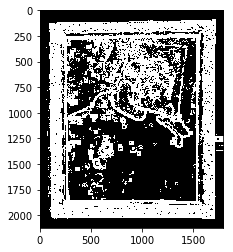

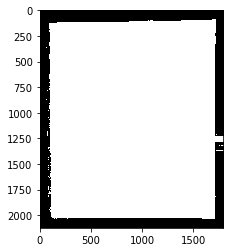

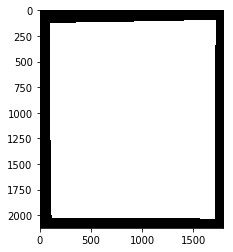

---------------------


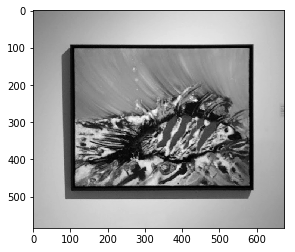

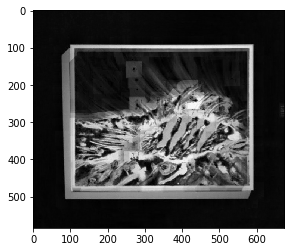

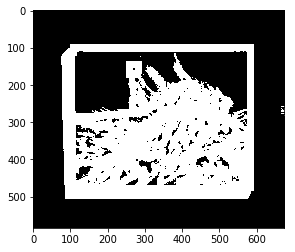

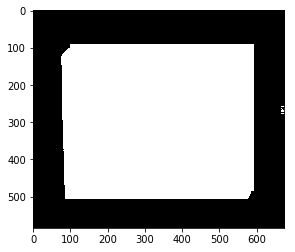

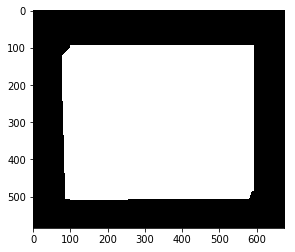

---------------------


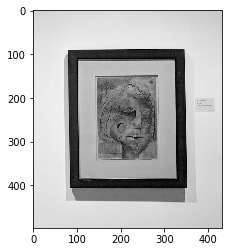

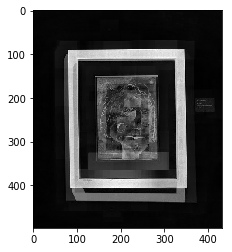

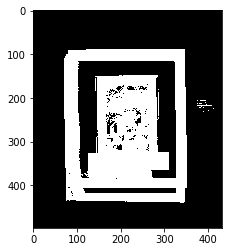

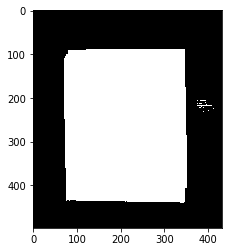

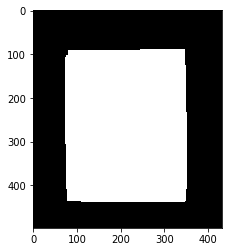

---------------------


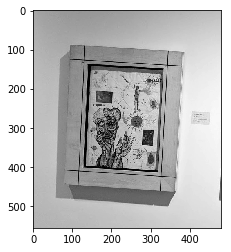

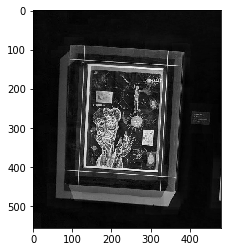

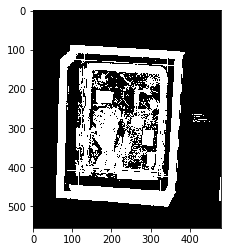

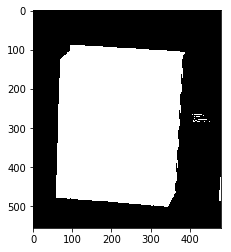

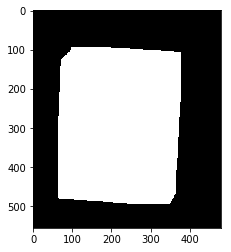

---------------------


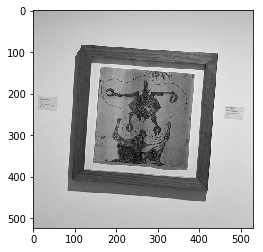

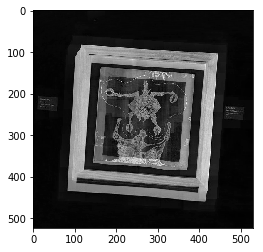

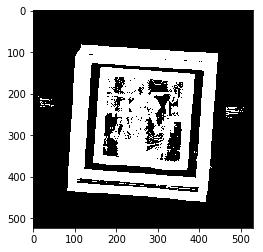

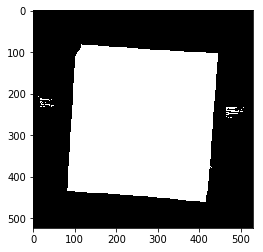

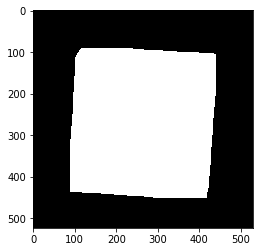

---------------------


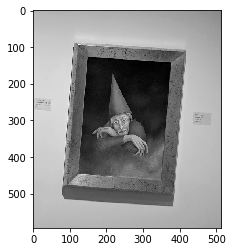

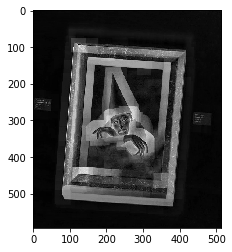

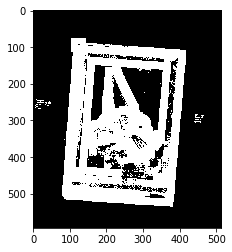

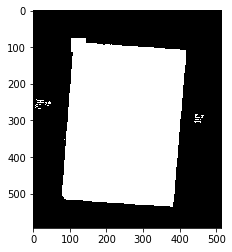

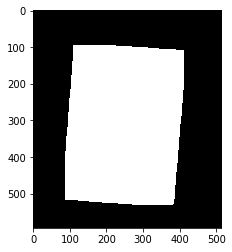

---------------------


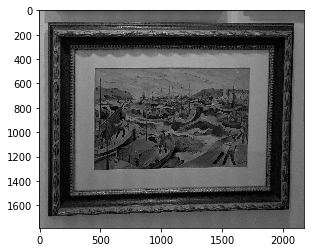

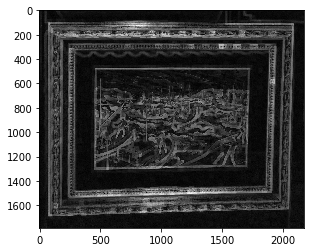

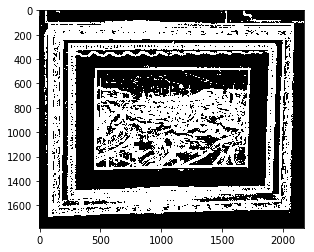

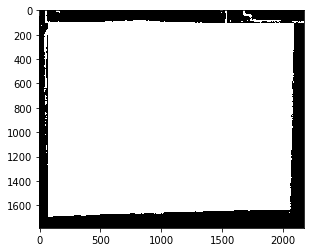

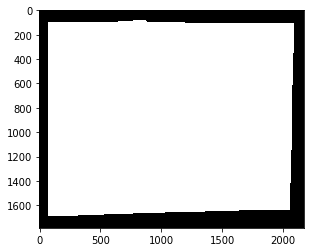

---------------------


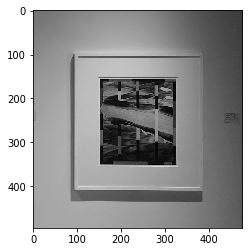

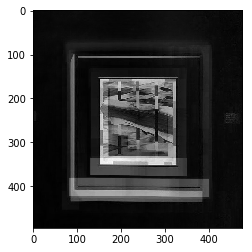

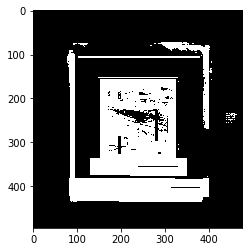

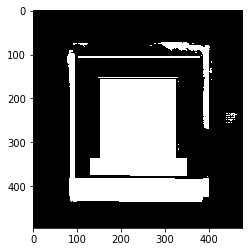

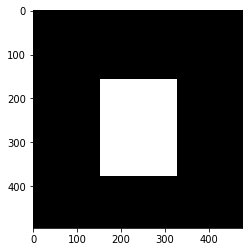

---------------------


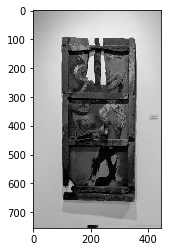

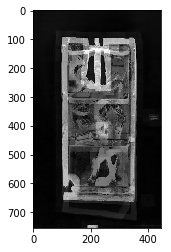

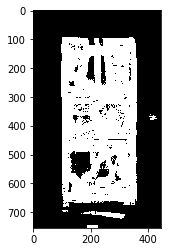

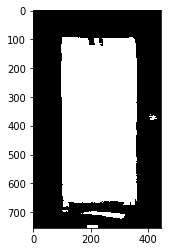

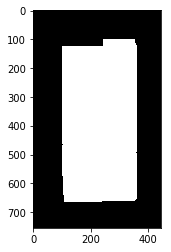

---------------------


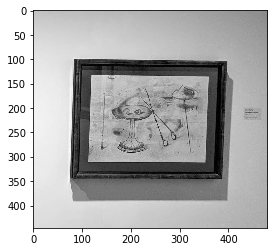

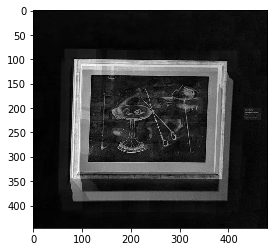

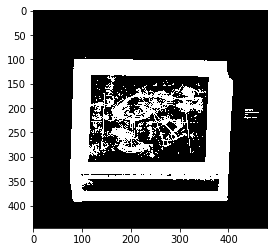

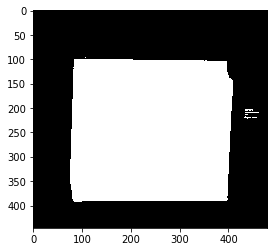

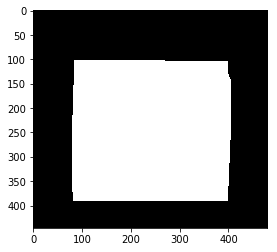

---------------------


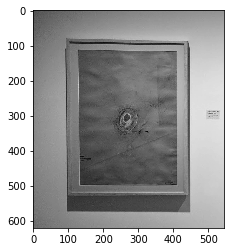

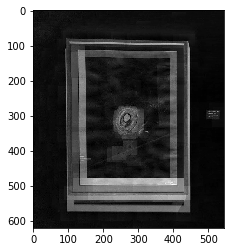

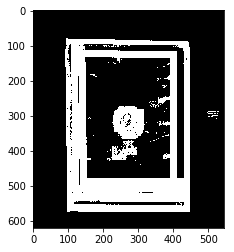

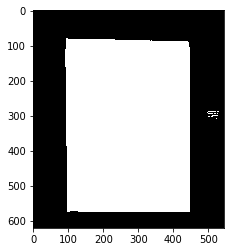

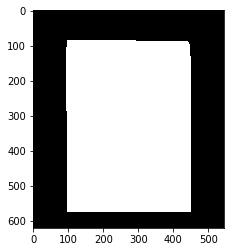

---------------------


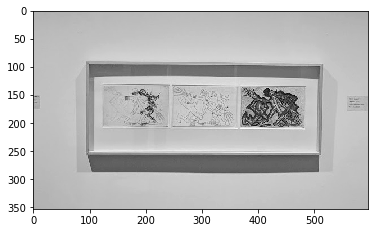

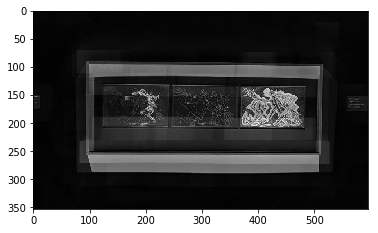

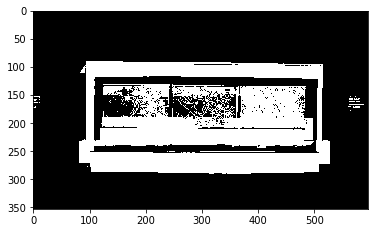

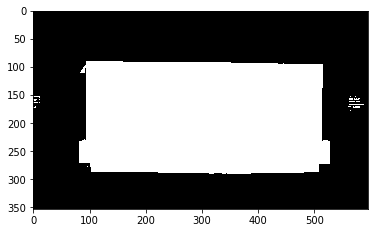

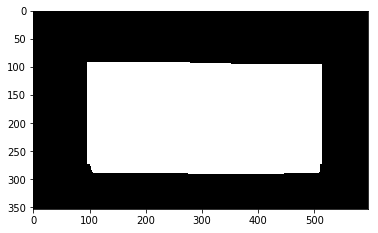

---------------------


In [5]:
queries = []
QUERY_SET = 'qsd2_w1'

qs_l = '../qs/' + QUERY_SET + '/*.jpg'

i=0
for f in sorted(glob.glob(qs_l)):
    # Read images
    name = os.path.splitext(os.path.split(f)[1])[0]
    img = cv.imread(f, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    plt.imshow(img, cmap = plt.cm.gray)
    plt.show()
    
    '''
    # Compute morphological gradient (dilation - erosion)
    kernel = np.ones((20,20),np.uint8)
    img_gradient = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)
    '''
    
    # Compute morphological gradient by dilation (keep inner edges to remove wall posters)
    kernel = np.ones((40,40),np.uint8)
    img_dilation = cv.dilate(img,kernel,iterations = 1)
    img_gradient = img_dilation - img
    
    plt.imshow(img_gradient, cmap = plt.cm.gray)
    plt.show()
    
    # Thresholding
    _,img_th = cv.threshold(img_gradient, 30, 255, cv.THRESH_BINARY)
    #retval,mask_img = cv.threshold(final_img, 30, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    
    plt.imshow(img_th, cmap = plt.cm.gray)
    plt.show()
    
    # Computing external contours
    contours, _ = cv.findContours(img_th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    #print(contours)
    img_contour = np.zeros_like(img_th)
    cv.drawContours(img_contour, contours, -1, 255, -1)
    plt.imshow(img_contour, cmap = plt.cm.gray)
    plt.show()
    
    # Opening to remove wall posters
    kernel = np.ones((100,100),np.uint8)
    mask = cv.morphologyEx(img_contour, cv.MORPH_OPEN, kernel)
    
    # Avoid all zeros image
    if(mask.any()==0):
        mask = img_contour
        
    plt.imshow(mask, cmap = plt.cm.gray)
    plt.show()
    
    print("---------------------")
   
    
     